Criteres de avaluation du rapports


- Quantité des questions traites
- Qualités des repponses
- Profondeur de reflexion

In [1]:
# imports
from mpi4py import MPI
import dolfinx # FEM in python
import matplotlib.pyplot as plt
import ufl # variational formulations
import numpy as np
import gmsh
import basix.ufl
import dolfinx.fem as fem
import dolfinx.fem.petsc
import utils
from eshelby import EshelbyDisk
import matplotlib.pyplot as plt
from dolfinx.fem import (Expression, Function, functionspace,
                         assemble_scalar, dirichletbc, form, locate_dofs_topological)

import pyvista # visualisation in python notebook
pyvista.start_xvfb()
pyvista.set_jupyter_backend("static")

In [2]:
def generate_mesh(
    R_i,
    R_e,
    mesh_size,
    aspect_ratio,
    mesh_order,
    ):

    mesh_comm = MPI.COMM_WORLD
    model_rank = 0
    gmsh.initialize()
    facet_names = {"inner_boundary": 1, "outer_boundary": 2}
    cell_names = {"inclusion": 1, "matrix": 2}
    model = gmsh.model()
    model.add("Disk")
    model.setCurrent("Disk")
    gdim = 2 # geometric dimension of the mesh
    inner_disk = gmsh.model.occ.addDisk(0, 0, 0, R_i, aspect_ratio * R_i)
    outer_disk = gmsh.model.occ.addDisk(0, 0, 0, R_e, R_e)
    whole_domain = gmsh.model.occ.fragment(
                [(gdim, outer_disk)], [(gdim, inner_disk)]
            )
    gmsh.model.occ.synchronize()
    # Add physical tag for bulk
    inner_domain = whole_domain[0][0]
    outer_domain = whole_domain[0][1]
    model.addPhysicalGroup(gdim, [inner_domain[1]], tag=cell_names["inclusion"])
    model.setPhysicalName(gdim, inner_domain[1], "Inclusion")
    model.addPhysicalGroup(gdim, [outer_domain[1]], tag=cell_names["matrix"])
    model.setPhysicalName(gdim, outer_domain[1], "Matrix")

    # Add physical tag for boundaries
    lines = gmsh.model.getEntities(dim=1)
    inner_boundary = lines[1][1]
    outer_boundary = lines[0][1]
    gmsh.model.addPhysicalGroup(1, [inner_boundary], facet_names["inner_boundary"])
    gmsh.model.addPhysicalGroup(1, [outer_boundary], facet_names["outer_boundary"])
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin",mesh_size)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax",mesh_size)
    model.mesh.generate(gdim)
    gmsh.option.setNumber("General.Terminal", 1)
    model.mesh.setOrder(mesh_order)
    gmsh.option.setNumber("General.Terminal", 0)

    # Import the mesh in dolfinx
    from dolfinx.io import gmshio
    domain, cell_tags, facet_tags = gmshio.model_to_mesh(model, mesh_comm, model_rank, gdim=gdim)
    domain.name = "composite"
    cell_tags.name = f"{domain.name}_cells"
    facet_tags.name = f"{domain.name}_facets"
    gmsh.finalize()

    return domain, cell_tags, facet_tags

def plot_mesh(
    R_i,
    R_e,
    aspect_ratio,
    mesh_size,
    mesh_order,
    ): 

    domain, cell_tags, facet_tags = generate_mesh(
        R_i,
        R_e,
        mesh_size,
        aspect_ratio,
        mesh_order,
    )

    topology, cells, geometry = dolfinx.plot.vtk_mesh(domain)
    function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
    function_grid["Marker"] = cell_tags.values
    plotter = pyvista.Plotter()
    plotter.add_mesh(function_grid, show_edges=True)
    plotter.show_bounds(grid='front', location='outer', all_edges=True)
    plotter.view_xy()
    plotter.show() 

def error_L2(uh, u_ex, degree_raise=3):
    # Create higher order function space
    degree = uh.function_space.ufl_element().degree
    family = uh.function_space.ufl_element().family_name
    mesh = uh.function_space.mesh
    W = functionspace(mesh, (family, degree + degree_raise))
    # Interpolate approximate solution
    u_W = dolfinx.fem.Function(W)
    u_W.interpolate(uh)

    # Interpolate exact solution, special handling if exact solution
    # is a ufl expression or a python lambda function
    u_ex_W = dolfinx.fem.Function(W)
    if isinstance(u_ex, ufl.core.expr.Expr):
        u_expr = Expression(u_ex, W.element.interpolation_points())
        u_ex_W.interpolate(u_expr)
    else:
        u_ex_W.interpolate(u_ex)

    # Compute the error in the higher order function space
    e_W = Function(W)
    e_W.x.array[:] = u_W.x.array - u_ex_W.x.array

    # Integrate the error
    error = form(ufl.inner(e_W, e_W) * ufl.dx)
    error_local = assemble_scalar(error)
    error_global = mesh.comm.allreduce(error_local, op=MPI.SUM)
    return np.sqrt(error_global)

def get_error(u_solution,u_analitical,domain,cell_tags,section):
    dx = ufl.Measure("dx", domain = domain, subdomain_data = cell_tags)
    if section == 0:

        norm_l2 = np.sqrt(utils.assemble_scalar(ufl.inner(u_solution,u_solution) * dx))
        u_error = u_solution-u_analitical
        error = np.sqrt(utils.assemble_scalar(ufl.inner(u_error,u_error) * dx))
    else:
        norm_l2 = np.sqrt(utils.assemble_scalar(ufl.inner(u_solution,u_solution) * dx(section)))
        u_error = u_solution-u_analitical
        error = np.sqrt(utils.assemble_scalar(ufl.inner(u_error,u_error) * dx(section)))
    return error,norm_l2

def solve_problem(
        domain,
        cell_tags,
        facet_tags,
        E_m,
        nu_m,
        E_i,
        nu_i,
        mesh_order
    ):

    ### Define the domain
    dx = ufl.Measure("dx", domain = domain, subdomain_data = cell_tags)
    V = fem.functionspace(domain, ("Lagrange", mesh_order, (domain.geometry.dim,)))

    ### Defining the elastic problem
    u = ufl.TrialFunction(V)
    u_bar = ufl.TestFunction(V)

    bilinear_form_inclusion = ufl.inner(sigma(eps(u),E_i,nu_i),eps(u_bar))*dx(1)
    bilinear_form_matrix = ufl.inner(sigma(eps(u),E_m,nu_m),eps(u_bar))*dx(2)
    bilinear_form = bilinear_form_inclusion + bilinear_form_matrix
    g=0.0 # no weight
    body_force = dolfinx.fem.Constant(domain, dolfinx.default_scalar_type((0,-g)))
    linear_form = (ufl.dot(body_force,u_bar)) * ufl.dx

    ### Applying boundry conditons
    outer_facets = facet_tags.find(2)
    outer_boundary_dofs = dolfinx.fem.locate_dofs_topological(V,domain.geometry.dim-1,outer_facets)
    uD = dolfinx.fem.Function(V)
    u_on_boundary = lambda x: np.array([-x[1], -x[0]], dtype=uD.x.array.dtype)
    uD.interpolate(u_on_boundary)
    bc = dolfinx.fem.dirichletbc(uD, outer_boundary_dofs)
    
    ### Solving the problem
    problem = dolfinx.fem.petsc.LinearProblem(
    bilinear_form, linear_form, bcs=[bc],
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
    )
    u_solution = problem.solve()

    return u_solution

def get_convergence_rate(results,mesh_sizes):
    convergence_rates = np.log(np.array(results[1:]) / np.array(results[:-1])) / np.log(mesh_sizes[1:] / mesh_sizes[:-1])
    convergence_rate = np.mean(np.sort(convergence_rates)[2:][:-2])
    return np.round(convergence_rate,2)

def eps(u):
    return ufl.sym(ufl.grad(u))

def sigma(eps, E, nu):
    I2 = ufl.Identity(2)
    mu = E/2/(1+nu)
    lamb = 2*mu*nu/(1-2*nu)
    return lamb*ufl.tr(eps)*I2 + 2*mu*eps

def get_mean_strain(u_solution,domain,cell_tags,component_1,coponent_2,section): 

    eps_solution = eps(u_solution)
    dx = ufl.Measure("dx", domain = domain, subdomain_data = cell_tags)
    if section == 1:
        dx = dx(1)
    elif section == 2:
        dx = (2)
    one = dolfinx.fem.Constant(domain,dolfinx.default_scalar_type(1.))
    area_domain = utils.assemble_scalar(dolfinx.fem.form(one * dx))
    V_eps = fem.functionspace(domain,("DG", 0))
    eps_expr = dolfinx.fem.Expression(eps_solution[component_1,coponent_2], V_eps.element.interpolation_points())
    _eps = dolfinx.fem.Function(V_eps)
    _eps.interpolate(eps_expr)
    eps_bar = utils.assemble_scalar(_eps * dx) / area_domain

    return eps_bar

Info    : Meshing 1D...                                                                                                                       
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.0008648s, CPU 0.000737s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 4.25016s, CPU 4.21329s)
Info    : 69923 nodes 139972 elements
Info    : Meshing 1D...                                                                                                                       
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.000507901s, CPU 0.000584s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 1.22

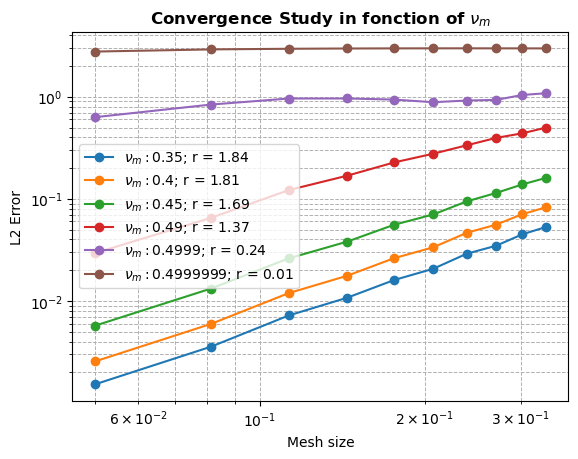

In [4]:
### Variation of the nu at the matrix

# Geometrique
R_i = 1.0 # Radius of the inclusion
R_e = 6.9  # Radius of the matrix (whole domain)
aspect_ratio = 1.0 # start with a circle, otherwise ellipse

# Materiaux
E_m = 1.0 # Young's modulus in matrix
list_nu_m = [0.35,0.40,0.45,0.49,0.4999,0.4999999] # Poisson's ratio in matrix
E_i = 11.0 # Young's modulus of inclusion
nu_i = 0.30 # Poisson's ratio in inclusion

# Mesh parameters
list_mesh_size = np.linspace(R_i/20,R_i/3,10)
section = 0

#### plot ####
list_mesh_order = [1]
for mesh_order in list_mesh_order:
    # Create a figure and axis
    fig, ax = plt.subplots()
    dict_plot = {}
    # Add titles and labels
    ax.set_title('Convergence Study in fonction of $\\nu_m$', fontweight='bold',)
    ax.set_xlabel('Mesh size')
    ax.set_ylabel('L2 Error')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)

    for nu_m in list_nu_m:

        dict_plot.update({nu_m:[]})
        
        for mesh_size in list_mesh_size:

            domain, cell_tags, facet_tags = generate_mesh(
                R_i =R_i,
                R_e = R_e, 
                aspect_ratio = aspect_ratio,
                mesh_size = mesh_size,
                mesh_order = mesh_order,  
            )

            u_solution = solve_problem(
                    domain,
                    cell_tags,
                    facet_tags,
                    E_m,
                    nu_m,
                    E_i,
                    nu_i,
                    mesh_order,
                )
            
            V = fem.functionspace(domain, ("Lagrange", mesh_order, (domain.geometry.dim,)))
            solution = EshelbyDisk(V,R_e/R_i, E_i/E_m, nu_i, nu_m)
            u_analitical = solution.to_function(R_i)

            error,norm = get_error(u_solution,u_analitical,domain,cell_tags,section)
            
            dict_plot[nu_m].append(error)

        conversion_rate = get_convergence_rate(dict_plot[nu_m],list_mesh_size)
        # Plot the error vs number of elements
        ax.plot(list_mesh_size, dict_plot[nu_m], marker='o', linestyle='-', label=f'$\\nu_m : {nu_m}$; r = {conversion_rate}')

    # Add grid for better readability
    # Add legend
    ax.legend()

    plt.savefig("conversion_poisson_in_matrix")
    # Show the plot
    plt.show()


Info    : Meshing 1D...                                                                                                                       
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.0005518s, CPU 0.000704s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.744494s, CPU 0.73602s)
Info    : 17662 nodes 35387 elements
Info    : Meshing 1D...                                                                                                                       
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.000422099s, CPU 0.000553s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.44

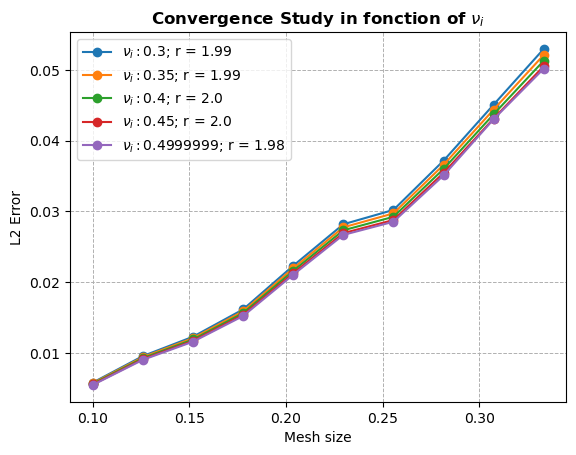

In [5]:
### Conversion with variation of the nu at the inclusion

# Geometrique
R_i = 1.0 # Radius of the inclusion
R_e = 6.9  # Radius of the matrix (whole domain)
aspect_ratio = 1.0 # start with a circle, otherwise ellipse

# Materiaux
E_m = 1.0 # Young's modulus in matrix
nu_m = 0.35 # Poisson's ratio in matrix
E_i = 11.0 # Young's modulus of inclusion
list_nu_i = [0.30,0.35,0.40,0.45,0.4999999]# Poisson's ratio in inclusion

# Mesh parameters
list_mesh_size = np.linspace(R_i/10,R_i/3,10)
section = 0

#### plot ####
mesh_order = 1
dict_plot = {}

# Create a figure and axis
fig, ax = plt.subplots()
# Add titles and labels
ax.set_title('Convergence Study in fonction of $\\nu_i$',fontweight='bold',)
ax.set_xlabel('Mesh size')
ax.set_ylabel('L2 Error')

for nu_i in list_nu_i:

    dict_plot.update({nu_i:[]})
    
    for mesh_size in list_mesh_size:

        domain, cell_tags, facet_tags = generate_mesh(
            R_i =R_i,
            R_e = R_e, 
            aspect_ratio = aspect_ratio,
            mesh_size = mesh_size,
            mesh_order = mesh_order,  
        )

        u_solution = solve_problem(
                domain,
                cell_tags,
                facet_tags,
                E_m,
                nu_m,
                E_i,
                nu_i,
                mesh_order,
            )
        
        V = fem.functionspace(domain, ("Lagrange", mesh_order, (domain.geometry.dim,)))
        solution = EshelbyDisk(V,R_e/R_i, E_i/E_m, nu_i, nu_m)
        u_analitical = solution.to_function(R_i)

        error,norm = get_error(u_solution,u_analitical,domain,cell_tags,section)
        
        dict_plot[nu_i].append(error)
        
    conversion_rate = get_convergence_rate(dict_plot[nu_i],list_mesh_size)
    # Plot the error vs number of elements
    ax.plot(list_mesh_size, dict_plot[nu_i], marker='o', linestyle='-', label=f'$\\nu_i : {nu_i}$; r = {conversion_rate}')

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
# Add legend
ax.legend()


plt.savefig("conversion_poisson_in_inclusion")
# Show the plot
plt.show()


In [6]:
### Variation of the nu at the matrix

# Geometrique
R_i = 1.0 # Radius of the inclusion
R_e = 6.9  # Radius of the matrix (whole domain)
aspect_ratio = 1.0 # start with a circle, otherwise ellipse

# Materiaux
E_m = 1.0 # Young's modulus in matrix
list_nu_m = [0.35,0.40,0.45,0.49,0.4999,0.4999999] # Poisson's ratio in matrix
E_i = 11.0 # Young's modulus of inclusion
nu_i = 0.30 # Poisson's ratio in inclusion

# Mesh parameters
list_mesh_size = np.linspace(R_i/20,R_i/3,10)
section = 0

#### plot ####
list_mesh_order = [1]
for mesh_order in list_mesh_order:
    # Create a figure and axis
    fig, ax = plt.subplots(1,2,)
    dict_plot = {}
    # Add titles and labels
    ax[0].set_title('Convergence Study in fonction of $\\nu_m$', fontweight='bold',)
    ax[0].set_xlabel('Mesh size')
    ax[0].set_ylabel('L2 Error')
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].grid(True, which='both', linestyle='--', linewidth=0.7)

    for nu_m in list_nu_m:

        dict_plot.update({nu_m:[]})
        
        for mesh_size in list_mesh_size:

            domain, cell_tags, facet_tags = generate_mesh(
                R_i =R_i,
                R_e = R_e, 
                aspect_ratio = aspect_ratio,
                mesh_size = mesh_size,
                mesh_order = mesh_order,  
            )

            u_solution = solve_problem(
                    domain,
                    cell_tags,
                    facet_tags,
                    E_m,
                    nu_m,
                    E_i,
                    nu_i,
                    mesh_order,
                )
            
            V = fem.functionspace(domain, ("Lagrange", mesh_order, (domain.geometry.dim,)))
            solution = EshelbyDisk(V,R_e/R_i, E_i/E_m, nu_i, nu_m)
            u_analitical = solution.to_function(R_i)

            error,norm = get_error(u_solution,u_analitical,domain,cell_tags,section)
            
            dict_plot[nu_m].append(error)

        conversion_rate = get_convergence_rate(dict_plot[nu_m],list_mesh_size)
        # Plot the error vs number of elements
        ax[0].plot(list_mesh_size, dict_plot[nu_m], marker='o', linestyle='-', label=f'$\\nu_m : {nu_m}$; r = {conversion_rate}')

    # Add grid for better readability
    # Add legend
    ax[0].legend()

    # plt.savefig("conversion_poisson_in_matrix")
    # Show the plot
    # plt.show()



### Conversion with variation of the nu at the inclusion

# Geometrique
R_i = 1.0 # Radius of the inclusion
R_e = 6.9  # Radius of the matrix (whole domain)
aspect_ratio = 1.0 # start with a circle, otherwise ellipse

# Materiaux
E_m = 1.0 # Young's modulus in matrix
nu_m = 0.35 # Poisson's ratio in matrix
E_i = 11.0 # Young's modulus of inclusion
list_nu_i = [0.30,0.35,0.40,0.45,0.4999999]# Poisson's ratio in inclusion

# Mesh parameters
list_mesh_size = np.linspace(R_i/10,R_i/3,10)
section = 0

#### plot ####
mesh_order = 1
dict_plot = {}

# Create a figure and axis
# fig, ax = plt.subplots()
# Add titles and labels
ax[1].set_title('Convergence Study in fonction of $\\nu_i$',fontweight='bold',)
ax[1].set_xlabel('Mesh size')
ax[1].set_ylabel('L2 Error')

for nu_i in list_nu_i:

    dict_plot.update({nu_i:[]})
    
    for mesh_size in list_mesh_size:

        domain, cell_tags, facet_tags = generate_mesh(
            R_i =R_i,
            R_e = R_e, 
            aspect_ratio = aspect_ratio,
            mesh_size = mesh_size,
            mesh_order = mesh_order,  
        )

        u_solution = solve_problem(
                domain,
                cell_tags,
                facet_tags,
                E_m,
                nu_m,
                E_i,
                nu_i,
                mesh_order,
            )
        
        V = fem.functionspace(domain, ("Lagrange", mesh_order, (domain.geometry.dim,)))
        solution = EshelbyDisk(V,R_e/R_i, E_i/E_m, nu_i, nu_m)
        u_analitical = solution.to_function(R_i)

        error,norm = get_error(u_solution,u_analitical,domain,cell_tags,section)
        
        dict_plot[nu_i].append(error)
        
    conversion_rate = get_convergence_rate(dict_plot[nu_i],list_mesh_size)
    # Plot the error vs number of elements
    ax[1].plot(list_mesh_size, dict_plot[nu_i], marker='o', linestyle='-', label=f'$\\nu_i : {nu_i}$; r = {conversion_rate}')

# Add grid for better readability
ax[1].grid(True, which='both', linestyle='--', linewidth=0.7)
# Add legend
ax[1].legend()


plt.savefig("mix")
# Show the plot
plt.show()



Info    : Meshing 1D...                                                                                                                       
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.0025277s, CPU 0.002892s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 4.78644s, CPU 4.78835s)
Info    : 69923 nodes 139972 elements
Info    : Meshing 1D...                                                                                                                       
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.001269s, CPU 0.001558s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 1.36803

: 

Info    : Meshing 1D...                                                                                                                       
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.0009914s, CPU 0.001189s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 4.2317s, CPU 4.23357s)
Info    : 69923 nodes 139972 elements
Info    : Meshing 1D...                                                                                                                       
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.000746805s, CPU 0.00094s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 1.8105

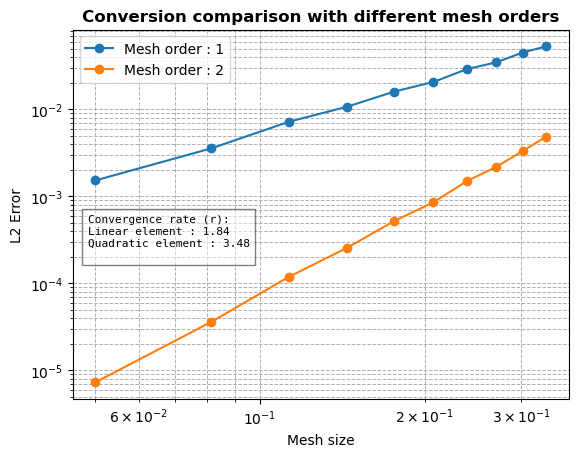

In [6]:
### Conversion comparison betewn mesh orders

# Geometrique
R_i = 1.0 # Radius of the inclusion
R_e = 6.9  # Radius of the matrix (whole domain)
aspect_ratio = 1.0 # start with a circle, otherwise ellipse

# Materiaux
E_m = 1.0 # Young's modulus in matrix
nu_m = 0.35 # Poisson's ratio in matrix
E_i = 11.0 # Young's modulus of inclusion
nu_i = 0.30 # Poisson's ratio in inclusion

# Mesh parameters
list_mesh_size = np.linspace(R_i/20,R_i/3,10)
section = 0

#### plot ####
list_mesh_order = [1,2]
dict_plot = {}

# Create a figure and axis
fig, ax = plt.subplots()
# Add titles and labels
ax.set_title('Conversion comparison with different mesh orders',fontweight='bold',)
ax.set_xlabel('Mesh size')
ax.set_ylabel('L2 Error')
ax.set_yscale('log')
ax.set_xscale('log')

for mesh_order in list_mesh_order:

    dict_plot.update({mesh_order:[]})
    
    for mesh_size in list_mesh_size:

        domain, cell_tags, facet_tags = generate_mesh(
            R_i =R_i,
            R_e = R_e, 
            aspect_ratio = aspect_ratio,
            mesh_size = mesh_size,
            mesh_order = mesh_order,  
        )

        u_solution = solve_problem(
                domain,
                cell_tags,
                facet_tags,
                E_m,
                nu_m,
                E_i,
                nu_i,
                mesh_order,
            )
        
        V = fem.functionspace(domain, ("Lagrange", mesh_order, (domain.geometry.dim,)))
        solution = EshelbyDisk(V,R_e/R_i, E_i/E_m, nu_i, nu_m)
        u_analitical = solution.to_function(R_i)

        error,norm = get_error(u_solution,u_analitical,domain,cell_tags,section)
        
        dict_plot[mesh_order].append(error)

    # Plot the error vs number of elements
    ax.plot(list_mesh_size, dict_plot[mesh_order], marker='o', linestyle='-', label=f'Mesh order : {mesh_order}')

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
# Add legend
ax.legend()

r_convergence_mesh_deg_1 = get_convergence_rate(dict_plot[1],list_mesh_size)
r_convergence_mesh_deg_2 = get_convergence_rate(dict_plot[2],list_mesh_size)

# Add a text box with LaTeX-style bold text
textstr = f'''Convergence rate (r):
Linear element : {np.round(r_convergence_mesh_deg_1,2)}
Quadratic element : {np.round(r_convergence_mesh_deg_2,2)}
'''

# Add a text box in the bottom left corner
ax.text(0.03, 0.5, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5), 
        fontfamily='monospace')  # Enable LaTeX

plt.savefig("coparison_mesh_order")
# Show the plot
plt.show()

Info    : Meshing 1D...                                                                                                                       
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.0005068s, CPU 0.000688s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.148237s, CPU 0.149758s)
Info    : 2992 nodes 6010 elements
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 30%] Meshing curve 2 order 2
Info    : [ 60%] Meshing surface 1 order 2
Info    : [ 80%] Meshing surface 2 order 2
Info    : Surface mesh: worst distortion = 0.838961 (0 elements in ]0, 0.2]); worst gamma = 0.754522
Info    : Done meshing order 2 (Wall 0.0208913s, CPU 0.021175s)
Info    : Meshing 1D...                                                                       

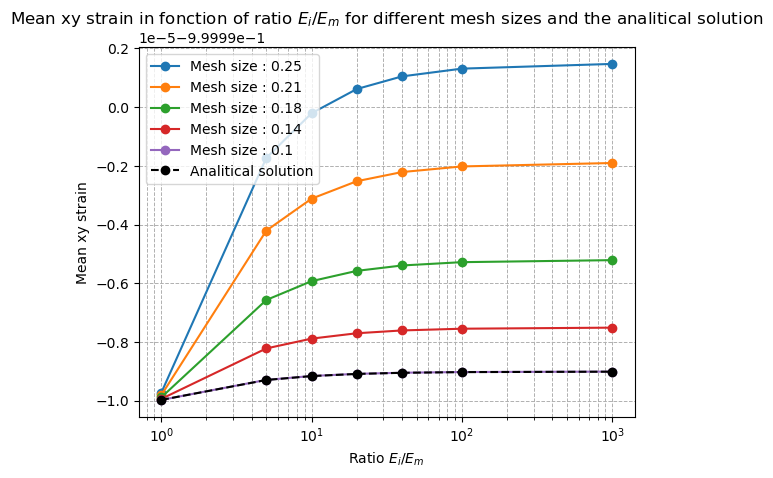

In [14]:
### Comparison shear strain with youngs module ratio

# Geometrique
R_i = 1.0 # Radius of the inclusion
R_e = 6.9  # Radius of the matrix (whole domain)
aspect_ratio = 1.0 # start with a circle, otherwise ellipse

# Materiaux
E_m = 1.0 # Young's modulus in matrix
nu_m = 0.35 # Poisson's ratio in matrix
list_E_i = [1,5,10,20,40,100,1000] # Young's modulus of inclusion
nu_i = 0.30 # Poisson's ratio in inclusion

# Mesh parameters
list_mesh_size = np.linspace(R_i/4,R_i/10,5)
section = 0

#### plot ####
list_mesh_order = 2
dict_plot = {}

# Create a figure and axis
fig, ax = plt.subplots()
# Add titles and labels
ax.set_title('Mean xy strain in fonction of ratio $E_i / E_m$ for different mesh sizes and the analitical solution')
ax.set_xlabel('Ratio $E_i / E_m$')
ax.set_ylabel('Mean xy strain')
# ax.set_yscale('log')
ax.set_xscale('log')


for mesh_size in list_mesh_size:

    dict_plot.update({mesh_size:[]})
    
    for E_i in list_E_i:

        domain, cell_tags, facet_tags = generate_mesh(
            R_i =R_i,
            R_e = R_e, 
            aspect_ratio = aspect_ratio,
            mesh_size = mesh_size,
            mesh_order = mesh_order,  
        )

        u_solution = solve_problem(
                domain,
                cell_tags,
                facet_tags,
                E_m,
                nu_m,
                E_i,
                nu_i,
                mesh_order,
            )

        mean_strain = get_mean_strain(u_solution,domain,cell_tags,0,1)
        
        dict_plot[mesh_size].append(mean_strain)

    # Plot the error vs number of elements
    ax.plot(list_E_i, dict_plot[mesh_size], marker='o', linestyle='-', label=f'Mesh size : {np.round(mesh_size,2)}')

dict_plot.update({"analitical":[]})
## Ploting the analitiacal solution
for E_i in list_E_i:

    #### analitical solution
    V = fem.functionspace(domain, ("Lagrange", mesh_order, (domain.geometry.dim,)))
    solution = EshelbyDisk(V,R_e/R_i, E_i/E_m, nu_i, nu_m)
    u_analitical = solution.to_function(R_i)
    eps_analitical = eps(u_analitical)

    mean_strain = get_mean_strain(u_analitical,domain,cell_tags,0,1)

    dict_plot["analitical"].append(mean_strain)

ax.plot(list_E_i, dict_plot["analitical"], marker='o', linestyle='--', color="black", label=f'Analitical solution')
# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
# Add legend
ax.legend()
plt.savefig("mean_strain")
# Show the plot
plt.show()

Info    : Meshing 1D...                                                                                                                       
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 60%] Meshing curve 2 (Ellipse)
Info    : Done meshing 1D (Wall 0.0032513s, CPU 0.000727s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0289126s, CPU 0.020156s)
Info    : 300 nodes 626 elements
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 30%] Meshing curve 2 order 2
Info    : [ 60%] Meshing surface 1 order 2
Info    : [ 80%] Meshing surface 2 order 2
Info    : Surface mesh: worst distortion = 0.89147 (0 elements in ]0, 0.2]); worst gamma = 0.841077
Info    : Done meshing order 2 (Wall 0.0042457s, CPU 0.003743s)
Info    : Meshing 1D...                                                                         

NameError: name 'list_E_i' is not defined

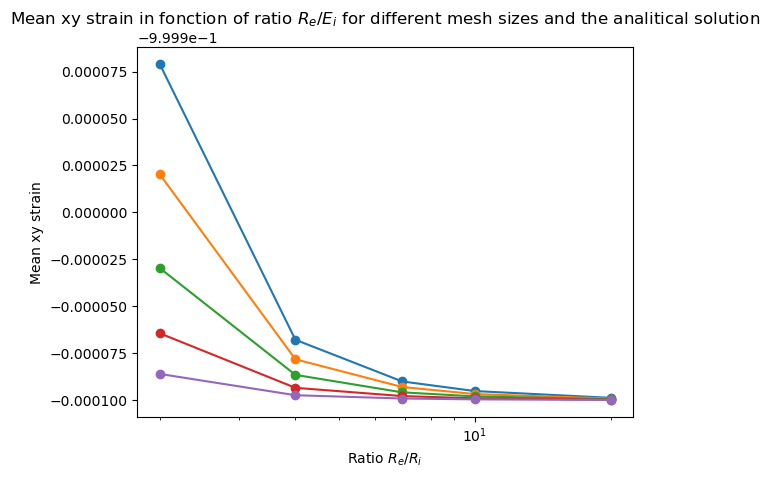

In [5]:
### Comparison shear strain with youngs module ratio

# Geometrique
R_i = 1.0 # Radius of the inclusion
list_R_e = [2,4,6.9,10,20]  # Radius of the matrix (whole domain)
aspect_ratio = 1.0 # start with a circle, otherwise ellipse

# Materiaux
E_m = 1.0 # Young's modulus in matrix
nu_m = 0.35 # Poisson's ratio in matrix
E_i = 11 # Young's modulus of inclusion
nu_i = 0.30 # Poisson's ratio in inclusion

# Mesh parameters
list_mesh_size = np.linspace(R_i/4,R_i/10,5)
section = 0

#### plot ####
mesh_order = 2
dict_plot = {}

# Create a figure and axis
fig, ax = plt.subplots()
# Add titles and labels
ax.set_title('Mean xy strain in fonction of ratio $R_e / E_i$ for different mesh sizes and the analitical solution')
ax.set_xlabel('Ratio $R_e / R_i$')
ax.set_ylabel('Mean xy strain')
ax.set_xscale('log')


for mesh_size in list_mesh_size:

    dict_plot.update({mesh_size:[]})
    
    for R_e in list_R_e:

        domain, cell_tags, facet_tags = generate_mesh(
            R_i = R_i,
            R_e = R_e, 
            aspect_ratio = aspect_ratio,
            mesh_size = mesh_size,
            mesh_order = mesh_order,  
        )

        u_solution = solve_problem(
                domain,
                cell_tags,
                facet_tags,
                E_m,
                nu_m,
                E_i,
                nu_i,
                mesh_order,
            )

        mean_strain = get_mean_strain(u_solution,domain,cell_tags,0,1,0)
        
        dict_plot[mesh_size].append(mean_strain)

    # Plot the error vs number of elements
    ax.plot(list_R_e, dict_plot[mesh_size], marker='o', linestyle='-', label=f'Mesh size : {np.round(mesh_size,2)}')

dict_plot.update({"analitical":[]})
## Ploting the analitiacal solution
for R_e in list_R_e:

    #### analitical solution
    V = fem.functionspace(domain, ("Lagrange", mesh_order, (domain.geometry.dim,)))
    solution = EshelbyDisk(V,R_e/R_i, E_i/E_m, nu_i, nu_m)
    u_analitical = solution.to_function(R_i)
    eps_analitical = eps(u_analitical)

    mean_strain = get_mean_strain(u_analitical,domain,cell_tags,0,1,0)

    dict_plot["analitical"].append(mean_strain)

ax.plot(list_E_i, dict_plot["analitical"], marker='o', linestyle='--', color="black", label=f'Analitical solution')
# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.7)
# Add legend
ax.legend()
plt.savefig("mean_strain_R_e")
# Show the plot
plt.show()